<a href="https://colab.research.google.com/github/cisprague/bts-2021/blob/main/notebooks/bts_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# System identification of AUVs with physics-informed learning

Christopher Iliffe Sprague \\
sprague@kth.se

Sriharsha Bhat \\
svbhat@kth.se

# Outline

- Background
- What's the benefit?
- Data generation
- Model identification
- Simulation
- Discussion and future work

# Resources

In [1]:
# JAX for autograd and and numerics
import jax.numpy as np
from jax import jit, vmap, jacobian, hessian, grad
from jax.experimental.ode import odeint
from jax.random import uniform, choice
from jax.nn import softplus, tanh
from jax.lax import stop_gradient

# Haiku for neural networks
!pip install git+https://github.com/deepmind/dm-haiku
import haiku as hk

# Optax for optimisation
!pip install git+https://github.com/deepmind/optax
import optax

# TQDM for training loop feedback
from tqdm.notebook import tqdm

# SKLearn for preprocessing data
from sklearn import preprocessing

# treating some arguments as static
from functools import partial

# matplotlib for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-fwogfcn9
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-fwogfcn9
  Created wheel for dm-haiku: filename=dm_haiku-0.0.5.dev0-py3-none-any.whl size=531899 sha256=74194a9dc0bce4aabaf49d975f00bd1a4c3d554963d5ee6d2bceaa1dd6805b6e
  Stored in directory: /tmp/pip-ephem-wheel-cache-x7_4h_le/wheels/06/28/69/ebaac5b2435641427299f29d88d005fb4e2627f4a108f0bdbc
Successfully built dm-haiku
  Cloning https://github.com/deepmind/optax to /tmp/pip-req-build-3prcfeot
  Running command git clone -q https://github.com/deepmind/optax /tmp/pip-req-build-3prcfeot
     |████████████████████████████████| 57 kB 2.9 MB/s 
  Created wheel for optax: filename=optax-0.0.9-py3-none-any.whl size=119477 sha256=13def71b796e701e261bab78e57f5d07ac499b23125ad63972228870ac83ac5e
  Stored in directory: /tmp/pip-ephem-wheel-cache-rwgu06k3/wheels/18/80/7e/f95870d651357f77f2ddeb452b3584a09053c224cc08d7fd86
Successfully 

# Analytical model

In [2]:
state_dim = 12
control_dim = 6

In [3]:
@jit
def skew(l):
  return np.array([
    [0, -l[2], l[1]],
    [l[2], 0, -l[0]],
    [-l[1], l[0], 0]
  ])

In [4]:
@jit
def f_analytical(state, control):

  # state and control
  x, y, z, phi, theta, psi, u, v, w, p, q, r = state
  rpm1, rpm2, de, dr, lcg, vbs = control

  # position and velocity
  eta = np.array([x, y, z, phi, theta, psi])
  nu = np.array([u, v, w, p, q, r])

  # scaled controls
  rpm1 *= 1000.0
  rpm2 *= 1000.0
  de *= 0.05
  dr *= 0.05
  # vbs *= 1.0
  # lcg *= 1.0

  # mass and inertia matrix
  m = 14.0
  I_o = np.diag(np.array([0.0294, 1.6202, 1.6202]))

  # centre of gravity, buoyancy, and pressure positions, resp.
  r_g = np.array([0.1 + lcg*0.01, 0.0, 0.0])
  r_b = np.array([0.1, 0.0, 0.0])
  r_cp = np.array([0.1, 0.0, 0.0])

  # <insert title>
  W = m*9.81
  B = W + vbs*1.5

  # hydrodynamic coefficients
  Xuu = 5. #3. #1.0
  Yvv = 20. #10. #100.0
  Zww = 50. #100.0
  Kpp = 0.1 #10.0
  Mqq = 20.#40 #100.0
  Nrr = 20. #150.0

  # control actuators
  K_T = np.array([0.0175, 0.0175])
  Q_T = np.array([0.001, -0.001])#*0.0

  # mass and inertia matrix
  M = np.block([
    [m*np.eye(3,3), -m*skew(r_g)],
    [m*skew(r_g), I_o]
  ])
  assert M.shape == (6,6), M

  # coriolis and centripetal matrix
  nu1 = np.array([u, v, w])
  nu2 = np.array([p, q, r])
  top_right = -m*skew(nu1) - m*skew(nu2)*skew(r_g)
  bottom_left = -m*skew(nu1) + m*skew(r_g)*skew(nu2)
  bottom_right = -skew(I_o.dot(nu2))
  C_RB = np.block([
    [np.zeros((3,3)), top_right],
    [bottom_left, bottom_right]
  ])
  assert C_RB.shape == (6, 6), C_RB

  # damping matrix
  forces = np.diag(np.array([Xuu*np.abs(u), Yvv*np.abs(v), Zww*np.abs(w)]))
  moments = np.diag(np.array([Kpp*np.abs(p), Mqq*np.abs(q), Nrr*np.abs(r)]))
  coupling = np.matmul(skew(r_cp), forces)
  D = np.block([[forces, np.zeros((3, 3))], [-coupling, moments]])
  assert D.shape == (6, 6), D

  # rotational transform between body and NED in Euler        
  T_euler = np.array([
    [1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
    [0, np.cos(phi), -np.sin(phi)],
    [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)],
  ])
  R_euler = np.array([
    [
      np.cos(psi)*np.cos(theta),
      -np.sin(psi)*np.cos(phi)+np.cos(psi)*np.sin(theta)*np.sin(phi),
      np.sin(psi)*np.sin(phi)+np.cos(psi)*np.cos(phi)*np.sin(theta)
    ],
    [
      np.sin(psi)*np.cos(theta),
      np.cos(psi)*np.cos(phi)+np.sin(phi)*np.sin(theta)*np.sin(psi),
      -np.cos(psi)*np.sin(phi)+np.sin(theta)*np.sin(psi)*np.cos(phi),
    ],
    [
      -np.sin(theta),
      np.cos(theta)*np.sin(phi),
      np.cos(theta)*np.cos(phi),
    ],
  ])
  assert R_euler.shape == (3,3), R_euler
  J_eta = np.block([
    [R_euler, np.zeros((3,3))],
    [np.zeros((3,3)), T_euler]
  ])
  assert J_eta.shape == (6,6), J_eta

  # buoyancy in quaternions
  f_g = np.array([0, 0, W])
  f_b = np.array([0, 0, -B])
  row1 = np.linalg.inv(R_euler).dot(f_g + f_b)
  row2 = skew(r_g).dot(np.linalg.inv(R_euler)).dot(f_g) + \
    skew(r_b).dot(np.linalg.inv(R_euler)).dot(f_b)
  geta = np.block([row1, row2])
  assert geta.shape == (6,), geta

  # <insert title>
  F_T = K_T.dot(np.array([rpm1, rpm2]))
  M_T = Q_T.dot(np.array([rpm1, rpm2]))
  tauc = np.array([
    F_T*np.cos(de)*np.cos(dr),
    -F_T*np.sin(dr),
    F_T*np.sin(de)*np.cos(dr),
    M_T*np.cos(de)*np.cos(dr),
    -M_T*np.sin(dr),
    M_T*np.sin(de)*np.cos(dr)
  ])
  assert tauc.shape == (6,), tauc

  # velocity and acceleration 
  etadot = np.block([J_eta.dot(nu)])
  assert etadot.shape == (6,)
  nudot = np.linalg.inv(M).dot(tauc - (C_RB + D).dot(nu - geta))
  assert nudot.shape == (6,)

  # state-space
  sdot = np.block([etadot, nudot])
  return sdot

# Generating data

We want to ensure percitant excitation to make sure we cover a variety of states.

To do this, we will simulate random state-feedback controllers. A straighforward way to do this is to simulate NN controllers with random parameters.

## Integration

In [5]:
# a single integration step for a single state
def rk4_step(f, x, u, h):
  k1 = h*f(x, u)
  k2 = h*f(x + k1/2, u)
  k3 = h*f(x + k2/2, u)
  k4 = h*f(x + k3, u)
  return x + (k1 + 2*k2 + 2*k3 + 4)/6

In [6]:
# a single step
def rk4_step_analytical(x, u, h):
  x = stop_gradient(x)
  u = stop_gradient(u)
  h = stop_gradient(h)
  return rk4_step(f_analytical, x, u, h)

# a single step for multiple states in parallel
rk4_steps_analytical = jit(vmap(rk4_step_analytical, in_axes=(0, 0, None)))

## Random training data

In [7]:
key = hk.PRNGSequence(42)
n_train = 10000
h = 0.1

In [8]:
states0 = uniform(
    next(key),
    shape=(n_train, state_dim),
    minval=np.array([-10, -10, -10, -np.pi, -np.pi, -np.pi, -5, -5, -5, -5, -5, -5]),
    maxval=np.array([10, 10, 10, np.pi, np.pi, np.pi, 5, 5, 5, 5, 5, 5])
)

In [9]:
controls = uniform(
    next(key),
    shape=(n_train, control_dim),
    minval=np.full(control_dim, -1, dtype=np.float32),
    maxval=np.full(control_dim, 1, dtype=np.float32)
)

In [10]:
states1 = rk4_steps_analytical(states0, controls, h)

In [166]:
scaler = preprocessing.StandardScaler().fit(states0)
mean = scaler.mean_
scale = scaler.scale_

## Visualisation

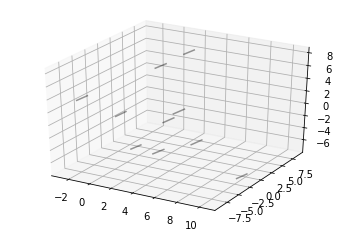

In [167]:
# TODO: add quiver
trajs = np.hstack((states0, states1)).reshape((-1, 2, 12))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(10):
  ax.plot(trajs[i,:,0], trajs[i,:,1], trajs[i,:,2], 'k-', alpha=0.4)
plt.show()

# Learning models

We will test a naïve multi-layer-perceptron model and a physics-informed model (https://arxiv.org/pdf/2106.00026.pdf).

## Naïve model

In [168]:
def F_naive(state, control):
  net = hk.nets.MLP([400, 400, 400, 12], activation=softplus)
  return net(np.hstack((state, control)))

## Physics-informed model

To learn the dynamics model from data we will use physics-informed learning: a way to constrain neural network models to obey the first-principles of physics.

We will model a Lagrangian to learn to conservative part of the dynamics.


$$
\ddot q = (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q
$$



In [169]:
def lagrangian(q, dq):
  net = hk.nets.MLP([200, 200, 200, 1], activation=softplus)
  return net(np.hstack((q, dq)))[0]

In [170]:
def F_conservative(state):
  q, dq = np.split(state, 2)
  ddq = jacobian(jacobian(lagrangian, 1), 0)(q, dq)
  ddq = ddq @ dq
  ddq = grad(lagrangian, 0)(q, dq) - ddq
  ddq = np.linalg.pinv(hessian(lagrangian, 1)(q, dq)) @ ddq
  return np.hstack((dq, ddq))

In [171]:
def F_non_conservative(state, control):
  net = hk.nets.MLP([200, 200, 200, 12], activation=softplus)
  return net(np.hstack((state, control)))

In [172]:
def F_decomposition(state, control):
  return f_conservative(state) + f_non_conservative(state, control)

# Loss function design

Let us assume that we will have a database of trajectories, either obtained through simulation of an analytical model or through robotic field data.



## Naïve model

In [173]:
f_naive = hk.without_apply_rng(hk.transform(F_naive))
params_naive = f_naive.init(next(key), states0[0,:], controls[0,:])

In [174]:
@jit
def rk4_step_naive(params, x, u, h):
  f = lambda x, u: f_naive.apply(params, (x - mean)/scale, u)
  return rk4_step(f, x, u, h)
rk4_steps_naive = jit(vmap(rk4_step_naive, in_axes=(None, 0, 0, None)))

In [175]:
rk4_step_naive(params_naive, states0[0,:], controls[0,:], h)

DeviceArray([ 0.2449125 , -0.05655587, -6.2279572 ,  2.4726357 ,
              2.3216276 ,  2.69352   ,  3.9206476 , -0.46681863,
              0.11823249,  4.7076797 , -2.4973526 ,  0.13987744],            dtype=float32)

In [176]:
def loss_naive(params):

  # integration step
  nn_states1 = rk4_steps_naive(params, states0, controls, h)

  # mean-squared error from analytical
  loss = np.average(np.square(nn_states1 - states1))
  return loss, loss

In [177]:
# gradient of loss function
grad_loss_naive = jit(grad(loss_naive, argnums=0, has_aux=True))

# Training

In [178]:
# setup optimiser and initialise its state
opt_init, opt_update = optax.chain(optax.scale_by_adam(), optax.scale(-1e-2))
opt_state = opt_init(params_naive)

In [179]:
# loss data
losses_naive = list()

In [180]:
# training loop
pb = tqdm(range(1000))
for _ in pb:

  # gradient and loss
  gopt, loss = grad_loss_naive(params_naive)

  # progress bar update
  pb.set_description('{:.6f}'.format(loss))

  # optimiser update
  updates, opt_state = opt_update(gopt, opt_state, params_naive)

  # update the parameters
  params_naive = optax.apply_updates(params_naive, updates)

# Results

## States and times

In [181]:
times = np.linspace(0, 5, 1000)
n_trajs = 1
i = choice(
  next(key), 
  np.arange(0, states0.shape[0]), 
  shape=(n_trajs,)
)
states = states0[i, :]

## Random control policy

In [182]:
# random NN controller
def Policy(state):
  net = hk.nets.MLP([200, 200, control_dim])
  return tanh(net(state))

In [183]:
policy = hk.without_apply_rng(hk.transform(Policy))
params_policy = policy.init(next(key), states0[0,:])

## Plotting

In [184]:
def plot(trajs_analytical=None, trajs_naive=None, trajs_decomposition=None):

  # setup
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # analytical
  if trajs_analytical is not None:
    for i in range(n_trajs):
      ax.plot(
        trajs_analytical[i,:1,0],
        trajs_analytical[i,:1,1],
        trajs_analytical[i,:1,2],
        'kx'
      )
      ax.plot(
        trajs_analytical[i,:,0], 
        trajs_analytical[i,:,1], 
        trajs_analytical[i,:,2], 
        'k-'
      )

  # naive
  if trajs_naive is not None:
    for i in range(n_trajs):
      ax.plot(
        trajs_naive[i,:1,0],
        trajs_naive[i,:1,1],
        trajs_naive[i,:1,2],
        'kx'
      )
      ax.plot(
        trajs_naive[i,:,0], 
        trajs_naive[i,:,1], 
        trajs_naive[i,:,2], 
        'k-'
      )

  # analytical
  if trajs_decomposition is not None:
    for i in range(n_trajs):
      ax.plot(
        trajs_decomposition[i,:1,0],
        trajs_decomposition[i,:1,1],
        trajs_decomposition[i,:1,2],
        'kx'
      )
      ax.plot(
        trajs_decomposition[i,:,0], 
        trajs_decomposition[i,:,1], 
        trajs_decomposition[i,:,2], 
        'k-'
      )

  plt.show()

## Analytical trajectories

In [185]:
@jit
def trajectory_analytical(params, state):
  params = stop_gradient(params)
  state = stop_gradient(state)
  traj = odeint(
      lambda x, t: f_analytical(x, policy.apply(params, x)),
      state,
      times
  )
  return traj

trajectories_analytical = jit(vmap(trajectory_analytical, in_axes=(None, 0)))

In [186]:
trajs_analytical = trajectories_analytical(params_policy, states)

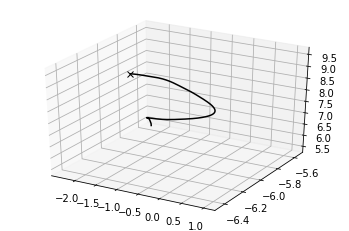

In [187]:
plot(trajs_analytical)

## Naïve trajectories

In [188]:
@jit
def trajectory_naive(params, state):
  params = stop_gradient(params)
  state = stop_gradient(state)
  def f(x, t):
    u = policy.apply(params, x)
    x = (x - mean)/scale
    return f_naive.apply(params_naive, x, u)
  traj = odeint(
      f,
      state,
      times
  )
  return traj

trajectories_naive = jit(vmap(trajectory_naive, in_axes=(None, 0)))

In [189]:
trajs_naive = trajectories_naive(params_policy, states)

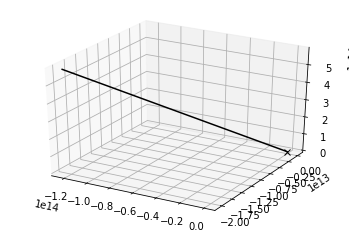

In [190]:
plot(trajs_naive)